# Housing Prices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
%matplotlib inline

In [2]:
# If you need to download the data
import opendatasets as od
od.download('https://www.kaggle.com/datasets/camnugent/california-housing-prices')

Skipping, found downloaded files in "./california-housing-prices" (use force=True to force download)


## Data Prep

In [3]:
def get_data(file):
    return pd.read_csv(file)

### Inspecting Data

In [4]:
def plot_histograms(df, variables: list):
    # Roughly set # rows and columns of axes based on # of plots
    if len(variables) <= 2:
        nrows=1
    elif len(variables) <= 6:
        nrows=2
    elif len(variables) <= 9:
        nrows=3
    else:
        nrows=4
    ncols = math.ceil(len(variables) / nrows)
    # Roughly set fig size
    if nrows >= 3:
        figsize = (14, 14)
    elif nrows >= 2:
        figsize = (14, 11)
    else:
        figsize = (14, 8)
    # Plot variables
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize = figsize)
    ax = ax.flatten()
    fig.suptitle('Distributions of IV\'s', fontsize = 32)
    for i in range(len(variables)):
        title = variables[i].replace('_', ' ').title()
        sns.histplot(df[variables[i]], bins=80, color='blue', ax=ax[i]).set(title=title)
    plt.tight_layout()

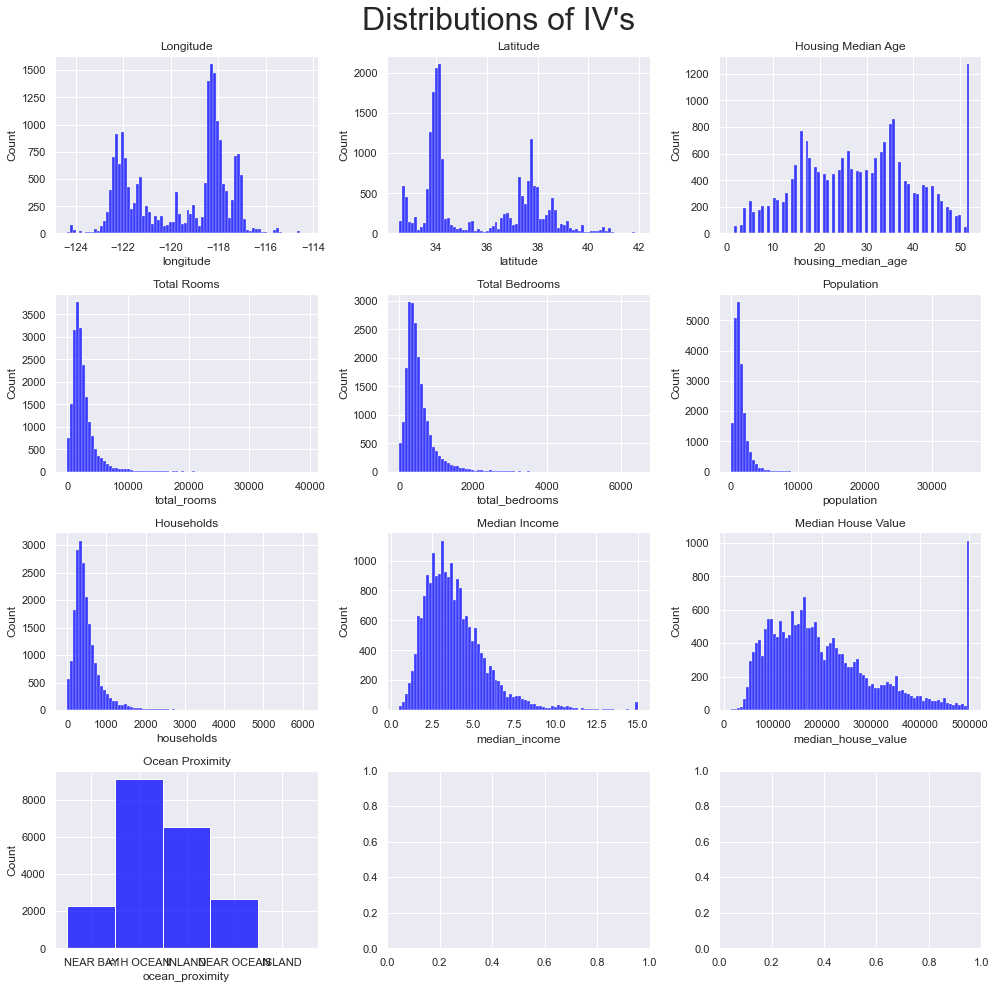

In [262]:
df = get_data('california-housing-prices/housing.csv')
sns.set()
plot_histograms(df, df.columns.values)

Many of these have long rightward tails, so I'm going to compare the performance of a model with 'logged' IV's with th e perf of one with unmodified IV's.

Since the DV, **median_house_value** appears to have its range limited by something like a 500,000+ option, I'm going to removed all datapoints with a 500,000 median value from the dataset.

I'm also going to add dummy variables for **ocean_proximity** and remove items with **null** for any features.

### Formatting Data

In [6]:
def add_log_vars(df):
    variables = ['total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', 'median_house_value']
    for var in variables:
        df['log_'+var] = np.log1p(df[var])
    return df

def add_ocean_categorical(df):
    for prox in df['ocean_proximity'].unique():
        df[prox] = (df['ocean_proximity'] == prox) * 1 
    del df['INLAND']
    return df

def remove_capped_values(df):
    return df[df['median_house_value'] < 500000]

def get_formatted_data(file, remove_cap=True):
    df = get_data(file)
    df = add_log_vars(df)
    df = add_ocean_categorical(df)
    df = df.dropna(how='any')
    if remove_cap:
        df = remove_capped_values(df)
    return df

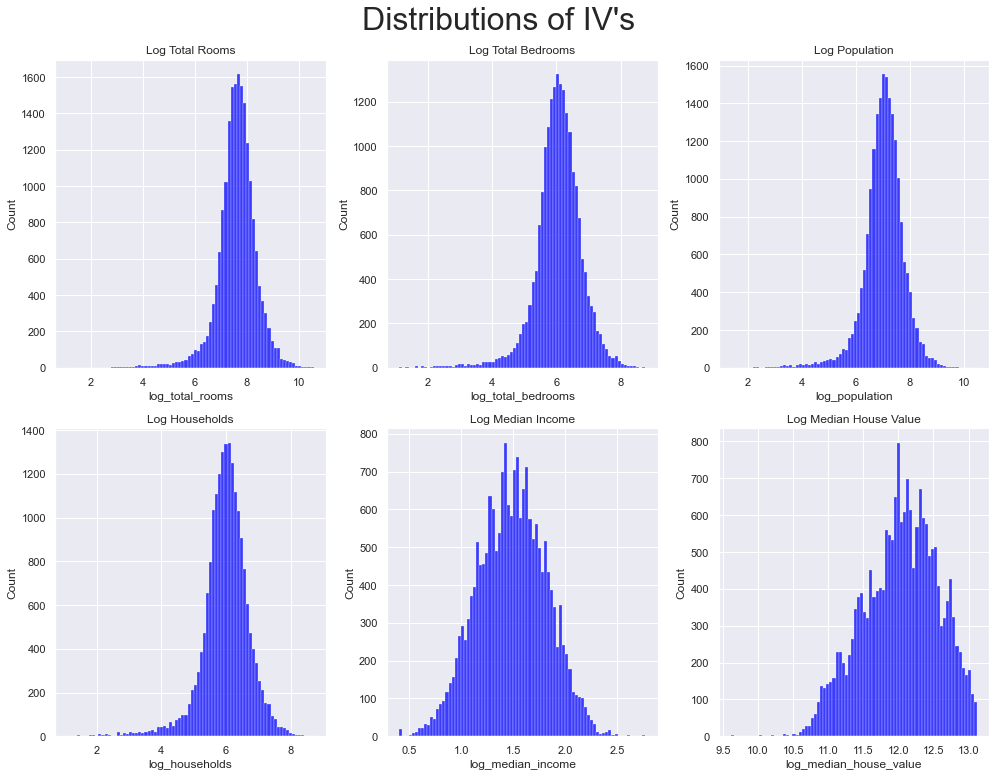

In [263]:
df = get_formatted_data('california-housing-prices/housing.csv')
variables = ['log_total_rooms', 'log_total_bedrooms', 'log_population', 
             'log_households', 'log_median_income', 'log_median_house_value']
plot_histograms(df, variables)

In [8]:
df.corr(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,log_total_rooms,log_total_bedrooms,log_population,log_households,log_median_income,log_median_house_value,NEAR BAY,<1H OCEAN,NEAR OCEAN,ISLAND
longitude,1.000000,-0.924093,-0.103025,0.045124,0.069887,0.101416,0.056804,-0.009082,-0.045250,0.029723,0.060738,0.112000,0.056520,-0.010608,-0.018300,-0.462908,0.312701,0.049788,0.009670
latitude,-0.924093,1.000000,0.006941,-0.033947,-0.067943,-0.113615,-0.073474,-0.078109,-0.149614,-0.030021,-0.069799,-0.144009,-0.091254,-0.080629,-0.195945,0.346368,-0.443861,-0.164955,-0.017118
housing_median_age,-0.103025,0.006941,1.000000,-0.371440,-0.327505,-0.294337,-0.309331,-0.195024,0.065761,-0.328738,-0.281107,-0.242835,-0.249291,-0.189555,0.042649,0.245796,0.050851,0.024787,0.017992
total_rooms,0.045124,-0.033947,-0.371440,1.000000,0.934233,0.859769,0.921697,0.223963,0.144051,0.787391,0.746634,0.685105,0.729057,0.235182,0.157764,-0.022611,-0.008324,-0.013002,-0.007677
total_bedrooms,0.069887,-0.067943,-0.327505,0.934233,1.000000,0.879269,0.979137,0.022125,0.075219,0.764396,0.813957,0.723658,0.787593,0.039603,0.096781,-0.019668,0.017916,0.003215,-0.004526
population,0.101416,-0.113615,-0.294337,0.859769,0.879269,1.000000,0.909035,0.042740,0.012789,0.687940,0.717762,0.794770,0.731393,0.054268,0.043963,-0.058192,0.077541,-0.021135,-0.010826
households,0.056804,-0.073474,-0.309331,0.921697,0.979137,0.909035,1.000000,0.046639,0.094630,0.763257,0.805740,0.756265,0.813069,0.064987,0.118459,-0.010778,0.042635,0.004988,-0.009392
median_income,-0.009082,-0.078109,-0.195024,0.223963,0.022125,0.042740,0.046639,1.000000,0.646887,0.233699,0.010221,0.038653,0.042562,0.975480,0.641825,0.047882,0.181510,-0.004692,-0.009522
median_house_value,-0.045250,-0.149614,0.065761,0.144051,0.075219,0.012789,0.094630,0.646887,1.000000,0.172948,0.087411,0.025252,0.111107,0.630514,0.954316,0.155921,0.288497,0.132956,0.031121
log_total_rooms,0.029723,-0.030021,-0.328738,0.787391,0.764396,0.687940,0.763257,0.233699,0.172948,1.000000,0.949132,0.866523,0.934086,0.264830,0.192504,-0.017444,0.016888,0.000060,-0.007645


### Partitioning Data for Validation

In [9]:
def partition(df: pd.DataFrame):
    length = len(df)
    index = np.arange(length)
    rng = np.random.default_rng()
    rng.shuffle(index)
    shuffled_df = df.iloc[index]
    # Train is 60%, Eval is 20% and Test is 20% of the data
    train_df = shuffled_df.iloc[: 3 * (length // 5)]
    eval_df = shuffled_df.iloc[3 * (length // 5): 4 * (length // 5)]
    test_df = shuffled_df.iloc[4 * (length // 5):]
    return train_df, eval_df, test_df

## Linear Model

### LM Estimation and Inference

In [10]:
def fit(features: pd.DataFrame, target: pd.DataFrame, reg_constant=0):
    features = features.copy()
    features['bias'] = np.ones(len(features))
    x = features.values
    features
    x_t = x.T
    x_t_x_inv = np.linalg.inv(x_t @ x + reg_constant * np.eye(x.shape[1]))
    y = target.values
    weights = x_t_x_inv @ x_t @ y
    return weights

In [11]:
def predictions(weights: np.ndarray, features: pd.DataFrame):
    features = features.copy()
    features['bias'] = np.ones(len(features))
    x = features.values
    return x @ weights

### General Fit Metrics

In [12]:
def RMSE(predictions: np.ndarray, target: np.ndarray):
    y_hat = predictions
    y = target
    rmse = np.sqrt(((y - y_hat) ** 2)).mean()
    return rmse

In [13]:
def r_squared(predictions: np.ndarray, target: np.ndarray):
    y_hat = predictions
    y = target
    TSS = ((y - y.mean()) ** 2).sum()
    RSS = ((y - y_hat) ** 2).sum()
    r_squared = 1 - RSS / TSS
    return r_squared

### Evaluation of Different Linear Models

#### RMSE and R_2 Testing Module

In [14]:
def test_performance(df: pd.DataFrame, feature_vars: list, target_var: str, num_tests=50):
    train = 0
    train_r2 = 0
    evaluation = 0
    eval_r2 = 0
    test = 0
    test_r2 = 0
    for i in range(num_tests):
        train_df, eval_df, test_df = partition(df)
        weights = fit(train_df[feature_vars], train_df[target_var]) 
        train += RMSE(predictions(weights, train_df[feature_vars]), train_df[target_var].values)
        evaluation += RMSE(predictions(weights, eval_df[feature_vars]), eval_df[target_var].values)
        test += RMSE(predictions(weights, test_df[feature_vars]), test_df[target_var].values)
        train_r2 += r_squared(predictions(weights, train_df[feature_vars]), train_df[target_var].values)
        eval_r2 += r_squared(predictions(weights, eval_df[feature_vars]), eval_df[target_var].values)
        test_r2 += r_squared(predictions(weights, test_df[feature_vars]), test_df[target_var].values)
    print('Test Results')
    print('~~~~~~~~~~~~')
    print(f'Training Data RMSE: {train/num_tests: .3f}')
    print(f'Eval Data RMSE:     {evaluation/num_tests: .3f}')
    print(f'Test Data RMSE:     {test/num_tests: .3f}')
    print(f'Training Data R^2:  {train_r2/num_tests: .3f}')
    print(f'Eval Data R^2:      {eval_r2/num_tests: .3f}')
    print(f'Test Data R^2:      {test_r2/num_tests: .3f}')
    print('~~~~~~~~~~~~')

In [15]:
df = get_formatted_data('california-housing-prices/housing.csv')
# Unmodified Features
features = ['housing_median_age', 'total_rooms', 'total_bedrooms','population', 
            'households', 'median_income', 'NEAR BAY', '<1H OCEAN', 'NEAR OCEAN', 
           ]
# Logged Features
features_log = ['housing_median_age', 'log_total_rooms', 'log_total_bedrooms', 
                'log_population', 'log_households', 'log_median_income', 
                'NEAR BAY', '<1H OCEAN', 'NEAR OCEAN']

In [16]:
# Testing with $500k entries removed
test_performance(df,  features, 'median_house_value')
test_performance(df,  features_log, 'median_house_value')
test_performance(df,  features, 'log_median_house_value')
test_performance(df,  features_log, 'log_median_house_value')

Test Results
~~~~~~~~~~~~
Training Data RMSE:  45098.365
Eval Data RMSE:      45058.307
Test Data RMSE:      45129.647
Training Data R^2:   0.601
Eval Data R^2:       0.600
Test Data R^2:       0.601
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  46430.909
Eval Data RMSE:      46436.533
Test Data RMSE:      46534.029
Training Data R^2:   0.592
Eval Data R^2:       0.592
Test Data R^2:       0.590
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.245
Eval Data RMSE:      0.245
Test Data RMSE:      0.246
Training Data R^2:   0.638
Eval Data R^2:       0.637
Test Data R^2:       0.634
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.235
Eval Data RMSE:      0.235
Test Data RMSE:      0.235
Training Data R^2:   0.657
Eval Data R^2:       0.657
Test Data R^2:       0.657
~~~~~~~~~~~~


In [17]:
#Testing with capped Housing price values
df = get_formatted_data('california-housing-prices/housing.csv', remove_cap=False)
test_performance(df,  features, 'median_house_value')
test_performance(df,  features_log, 'median_house_value')
test_performance(df,  features, 'log_median_house_value')
test_performance(df,  features_log, 'log_median_house_value')

Test Results
~~~~~~~~~~~~
Training Data RMSE:  50565.468
Eval Data RMSE:      50493.220
Test Data RMSE:      50564.172
Training Data R^2:   0.633
Eval Data R^2:       0.633
Test Data R^2:       0.633
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  52692.826
Eval Data RMSE:      52812.892
Test Data RMSE:      52749.549
Training Data R^2:   0.626
Eval Data R^2:       0.626
Test Data R^2:       0.626
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.257
Eval Data RMSE:      0.258
Test Data RMSE:      0.257
Training Data R^2:   0.647
Eval Data R^2:       0.644
Test Data R^2:       0.645
~~~~~~~~~~~~
Test Results
~~~~~~~~~~~~
Training Data RMSE:  0.240
Eval Data RMSE:      0.240
Test Data RMSE:      0.240
Training Data R^2:   0.684
Eval Data R^2:       0.682
Test Data R^2:       0.682
~~~~~~~~~~~~


In [18]:
def plot_error(predictions: np.ndarray, target: pd.DataFrame, title:str):
    RSE = np.sqrt((preds - target)**2)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 8))
    ax = ax.flatten()
    sns.histplot(target, bins=40, color='blue', alpha=.5, ax=ax[0],
                 label='Estimated').set(title='Predicted vs Real House Value')
    sns.histplot(predictions, bins=50, color='red', label='Predicted', ax=ax[0])
    ax[0].legend()
    sns.histplot(RSE, bins=40, color='blue', alpha=0.5, ax=ax[1]).set(title='Distribution of Pred Errors')
    if title is not None:
        fig.suptitle(title, fontsize=32)
    plt.tight_layout()

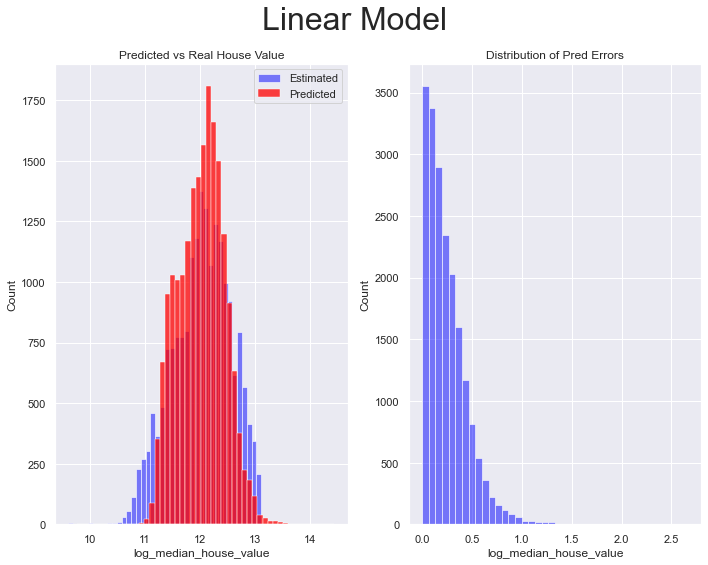

In [264]:
df = get_formatted_data('california-housing-prices/housing.csv', remove_cap=True)
train_df, eval_df, _ = partition(df)
weights = fit(eval_df[features], eval_df['log_median_house_value'])
preds = predictions(weights, df[features])
plot_error(preds, df['log_median_house_value'], title='Linear Model')

In [176]:
def sigma_squared(weights: np.ndarray, features: pd.DataFrame, target: pd.DataFrame):
    y_hat = predictions(weights, features)
    y = target.values
    mean_squared_error = ((y - y_hat) ** 2).mean()
    print(mean_squared_error)
    return mean_squared_error



def coefficient_table(weights: np.ndarray, features: pd.DataFrame, target: pd.DataFrame):
    var_names = list(features.columns.values)
    var_names.append('Intercept')
    x = features.values
    x = np.column_stack((x, np.ones(x.shape[0])))
    x_t_x_inv = np.linalg.inv(x.T @ x)
    variance = sigma_squared(weights, features, target) * x_t_x_inv
    standard_errors = np.sqrt(variance.diagonal())
    coeff_table = pd.DataFrame({'Variable': var_names, 'Coefficient': list(weights), 'SE': standard_errors})
    print(coeff_table)

In [243]:
coefficient_table(weights, df[features], df['log_median_house_value'])

0.10288677647006166
             Variable  Coefficient        SE
0  housing_median_age     0.003624  0.000214
1         total_rooms    -0.000052  0.000004
2      total_bedrooms     0.000435  0.000033
3          population    -0.000160  0.000005
4          households     0.000387  0.000035
5       median_income     0.202990  0.001984
6            NEAR BAY     0.447227  0.008866
7           <1H OCEAN     0.450066  0.005930
8          NEAR OCEAN     0.477637  0.007929
9           Intercept    10.819310  0.010823


## Non-Linear MLP

### Model Initialization

In [244]:
import torch.nn as nn

class Model(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.lin1 = nn.Linear(9, nodes)
        self.lin2 = nn.Linear(nodes, 1)
        #self.lin3 = nn.Linear(nodes, 1)
        #self.lin4 = nn.Linear(30, 1)
        self.act = torch.nn.ReLU()
    def forward(self, x):
        return self.lin2(self.act(self.lin1(x)))

def train_epoch(model, batches, target, optimizer, device, criterion):
    running_loss = 0
    for i, batch in enumerate(batches):
        batch = batch.to(device)
        pred = model(batch).squeeze()
        loss = torch.sqrt(criterion(pred, target[i]))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        running_loss += loss.item()
    return running_loss

def batchify(data, batch_size):
    num_batches = data.shape[0] // batch_size
    batch_list = [data[batch_size * i: batch_size * (i + 1)] for i in range(num_batches)]
    return batch_list

### Model Training

In [255]:
def train(model, optimizer, num_epochs, train_df, device='mps', new_lr=None):
    criterion = nn.MSELoss()
    if new_lr is not None:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

    train_data = torch.from_numpy(train_df[features].values).type(torch.float32)
    train_targets = torch.from_numpy(train_df['log_median_house_value'].values).type(torch.float32)

    train_batches = batchify(train_data, 256)
    train_targ_batches = batchify(train_targets, 256)

    for i in range(num_epochs):
        epoch_loss = train_epoch(model, train_batches, train_targ_batches, optimizer, device, criterion)
        if i % 100 == 0:
            print('epoch', i)
            print(epoch_loss)

In [246]:
df = get_formatted_data('california-housing-prices/housing.csv')
train_df, eval_df, test_df = partition(df)
model = Model(10).to('cpu')
optimizer = optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00005)

In [256]:
train(model, optimizer, 4000, train_df, device='cpu', new_lr=0.0002)

epoch 0
14.38688337802887
epoch 100
14.385258793830872
epoch 200
14.383245795965195
epoch 300
14.381270200014114
epoch 400
14.379353910684586
epoch 500
14.377475172281265
epoch 600
14.37531328201294
epoch 700
14.373369187116623
epoch 800
14.371336549520493
epoch 900
14.369618862867355
epoch 1000
14.367057532072067
epoch 1100
14.365066707134247
epoch 1200
14.364052385091782
epoch 1300
14.361345797777176
epoch 1400
14.360523402690887
epoch 1500
14.35787719488144
epoch 1600
14.35619604587555
epoch 1700
14.354382812976837
epoch 1800
14.352849870920181
epoch 1900
14.35108831524849
epoch 2000
14.349277138710022
epoch 2100
14.347178131341934
epoch 2200
14.346551239490509
epoch 2300
14.343372702598572
epoch 2400
14.342305719852448
epoch 2500
14.340548008680344
epoch 2600
14.338863909244537
epoch 2700
14.338513642549515
epoch 2800
14.336602002382278
epoch 2900
14.334865778684616
epoch 3000
14.331981092691422
epoch 3100
14.33145135641098
epoch 3200
14.329657077789307
epoch 3300
14.32792389392852

### Evaluation

In [259]:
preds = model(torch.from_numpy(eval_df[features].values).type(torch.float32)).detach().squeeze().numpy()
target = torch.from_numpy(eval_df['log_median_house_value'].values)
print('Non-Linear MLP RMSE:', RMSE(preds, target).item())
print('Non-Linear MLP R_2:', r_squared(preds, target).item())

Non-Linear MLP RMSE: 0.25327735872940715
Non-Linear MLP R_2: 0.6024940619544392


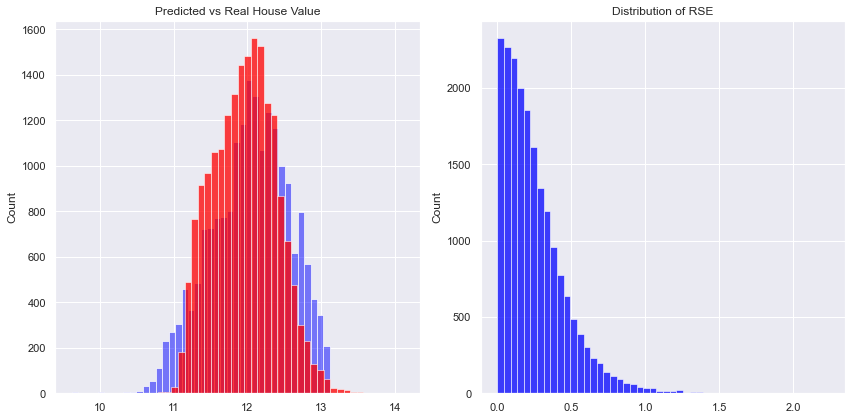

In [265]:
y = df['log_median_house_value'].values
y_hat = model(torch.from_numpy(df[features].values).type(torch.float32)).detach().numpy().squeeze()
RSE = np.sqrt((y - y_hat) ** 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax = ax.flatten()
sns.histplot(y, bins=40, color='blue', alpha=.5, label='Real', 
             ax=ax[0]).set(title='Predicted vs Real House Value')
sns.histplot(y_hat[y_hat > 9.5], bins=45, color='red', label='Predicted', ax=ax[0])
sns.histplot(RSE, bins=50, color='blue', ax=ax[1]).set(title='Distribution of RSE')

plt.tight_layout()